<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/41_hier_poisson.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(hier_poisson_model)=
# Modello gerarchico di Poisson

In questo capitolo, proseguiremo la discussione sul modello gerarchico bayesiano utilizzando PyMC, concentrandoci questa volta sul caso in cui i dati seguono una distribuzione di Poisson.

Esaminiamo il problema di determinare quanti pazienti segue in media uno psicologo professionista. Il numero medio di casi per uno psicologo può variare considerevolmente, in base alle aree di specializzazione, all'ambiente di lavoro e al numero di ore che lo psicologo decide di lavorare ogni settimana. Una ricerca condotta dall'American Psychological Association (APA) rivela che quasi il 42% dei psicologi negli Stati Uniti lavora, in media, tra le 40 e le 49 ore a settimana. Ciò indica che la maggior parte degli psicologi a tempo pieno ha un carico di lavoro che varia tra i 15 e i 20 clienti in un determinato momento.

In questo capitolo, esamineremo il modello gerarchico di Poisson utilizzando dati simulati. Immagineremo che i dati siano frutto di una ricerca condotta attraverso interviste a 30 psicologi, selezionati casualmente dall'Ordine degli Psicologi, in cinque regioni italiane. Durante le interviste, viene chiesto a ciascun psicologo quanti pazienti stia seguendo al momento.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
import scipy.stats as stats
from scipy.stats import gaussian_kde
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [48]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
import matplotlib.style as style 
style.use("tableau-colorblind10")

## Preparazione del notebook

Importiamo un set di dati simulati. La variabile `location` fornisce un codice numerico identificativo per cinque diverse regioni italiane in cui sono stati effettuati i rilevamenti dei dati. La variabile `patients` indica il numero di pazienti seguiti da ciascuno dei 30 psicologi intervistati in ciascuna delle cinque regioni. 

In [72]:
dat_wide = pd.read_csv("../data/region_patients_wide.csv")
print(dat_wide.head())

   location_1  location_2  location_3  location_4  location_5
0          12           7           7           8          15
1          12           4           6           9          10
2           6           6           9           7          12
3          13           9           6          14          10
4          12           3          15           6           6


In [73]:
dat_wide.shape

(30, 5)

Esaminiamo i dati con un istogramma.

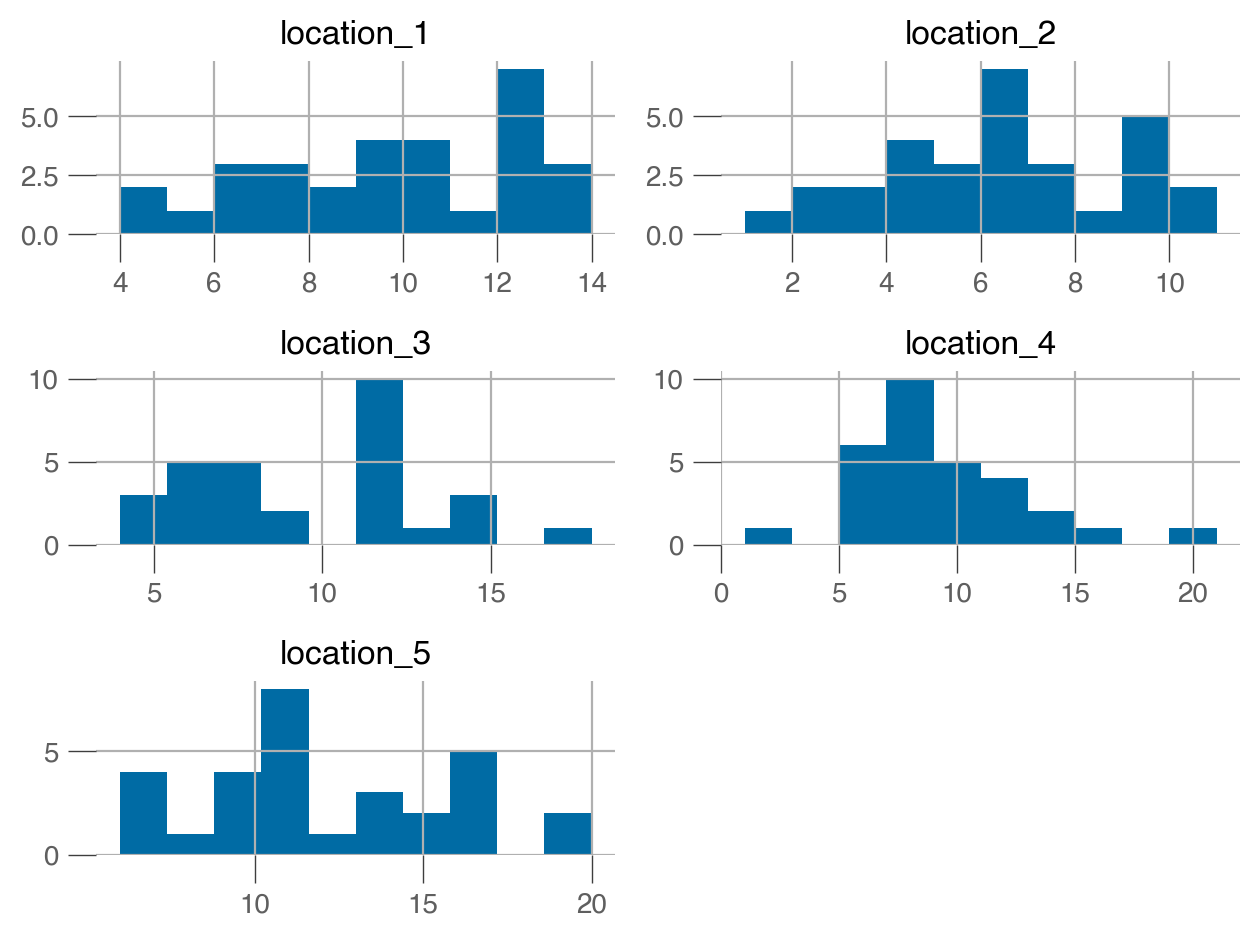

In [74]:
dat_wide.hist()
plt.tight_layout()
plt.show()

## Modello con pooling completo

Iniziamo il nostro processo di modellazione considerando un modello che tralascia l'informazione sul raggruppamento dei dati nelle 5 regioni diverse. Per implementare il modello con pooling completo iniziamo a trasformare i dati in formato long.

In [89]:
# Fare una copia così da non cambiare il DataFrame originale
dw = dat_wide.copy()

# Reset dell'indice per utilizzarlo come una colonna
dw.reset_index(inplace=True)

# Convertire il DataFrame in formato long utilizzando melt
dat_long = pd.melt(dw, id_vars=['index'], var_name='location', value_name='patients')

# Rinominare la colonna 'index' in 'obs' per maggiore chiarezza
dat_long.rename(columns={'index': 'obs'}, inplace=True)

# Visualizzare il DataFrame risultante
print(dat_long)

     obs    location  patients
0      0  location_1        12
1      1  location_1        12
2      2  location_1         6
3      3  location_1        13
4      4  location_1        12
..   ...         ...       ...
145   25  location_5        11
146   26  location_5        11
147   27  location_5        19
148   28  location_5        11
149   29  location_5        15

[150 rows x 3 columns]


Il modello con pooling completo sarà basato sulle seguenti componenti:

1. **Verosimiglianza di Poisson**: Partiamo dall'assunzione che la variabile `patients`, che indica il numero di pazienti in cura presso ciascun psicologo, segua una distribuzione di Poisson. Il parametro di questa distribuzione, chiamato `rate`, è sconosciuto e verrà stimato dal modello.

2. **Distribuzione Gamma per il parametro `rate`**: Per rappresentare l'incertezza riguardo al parametro `rate`, utilizziamo una distribuzione a priori Gamma. In PyMC, la distribuzione Gamma è definita da due parametri, $\mu$ e $\sigma$, che rappresentano rispettivamente la media e la deviazione standard della distribuzione.

3. **Iper-parametri $\mu$ e $\sigma$**: Invece di fissare dei valori specifici per $\mu$ e $\sigma$, consideriamo questi come iper-parametri del nostro modello. Per ciascuno di essi, utilizziamo una distribuzione a priori per rappresentare l'incertezza che abbiamo su tali parametri. Dato che sia $\mu$ che $\sigma$ devono essere positivi, optiamo per una distribuzione Half-Normal, una variante della distribuzione normale troncata sulla parte positiva. Nello specifico, scegliamo una deviazione standard di 10 per $\mu$ e di 20 per $\sigma`.

Il codice PyMC corrispondente a questo modello è il seguente:

In [53]:
with pm.Model() as model_pooling:
    y_data = pm.ConstantData("y_data", dat_long["patients"])
    h_mu = pm.HalfNormal("h_mu", sigma=10)
    h_sigma = pm.HalfNormal("h_sigma", sigma=20)
    rate = pm.Gamma("rate", mu=h_mu, sigma=h_sigma)
    y_obs = pm.Poisson("y_obs", mu=rate, observed=y_data)

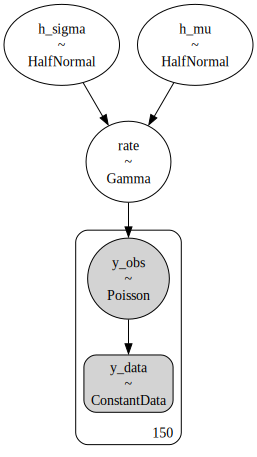

In [54]:
pm.model_to_graphviz(model_pooling)

Eseguiamo il prior preditive check.

In [55]:
with model_pooling:
    idata_pooling_prior_pred = pm.sample_prior_predictive(samples=100, random_seed=rng)

Sampling: [h_mu, h_sigma, rate, y_obs]


I valori della distribuzione predittiva a priori sono contenuti nell'oggetto `idata_pooling_prior_pred`.

In [56]:
idata_pooling_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

Li possiamo estrarre nel modo seguente. Si noti che sono contenuti in un array di dimensioni 1 x 100 x 150.

In [57]:
foo = idata_pooling_prior_pred.prior_predictive.y_obs
foo.shape

(1, 100, 150)

Possiamo trasformare questo array in un vettore unidimensionale nel modo seguente.

In [58]:
# Extract the likelihood samples
likelihood_samples = idata_pooling_prior_pred.prior_predictive.y_obs
flattened_array = np.ravel(likelihood_samples.values)

print(flattened_array)

[ 0  0  0 ... 14 10 14]


A qusto punto possiamo creare il grafico per il prior preditive check.

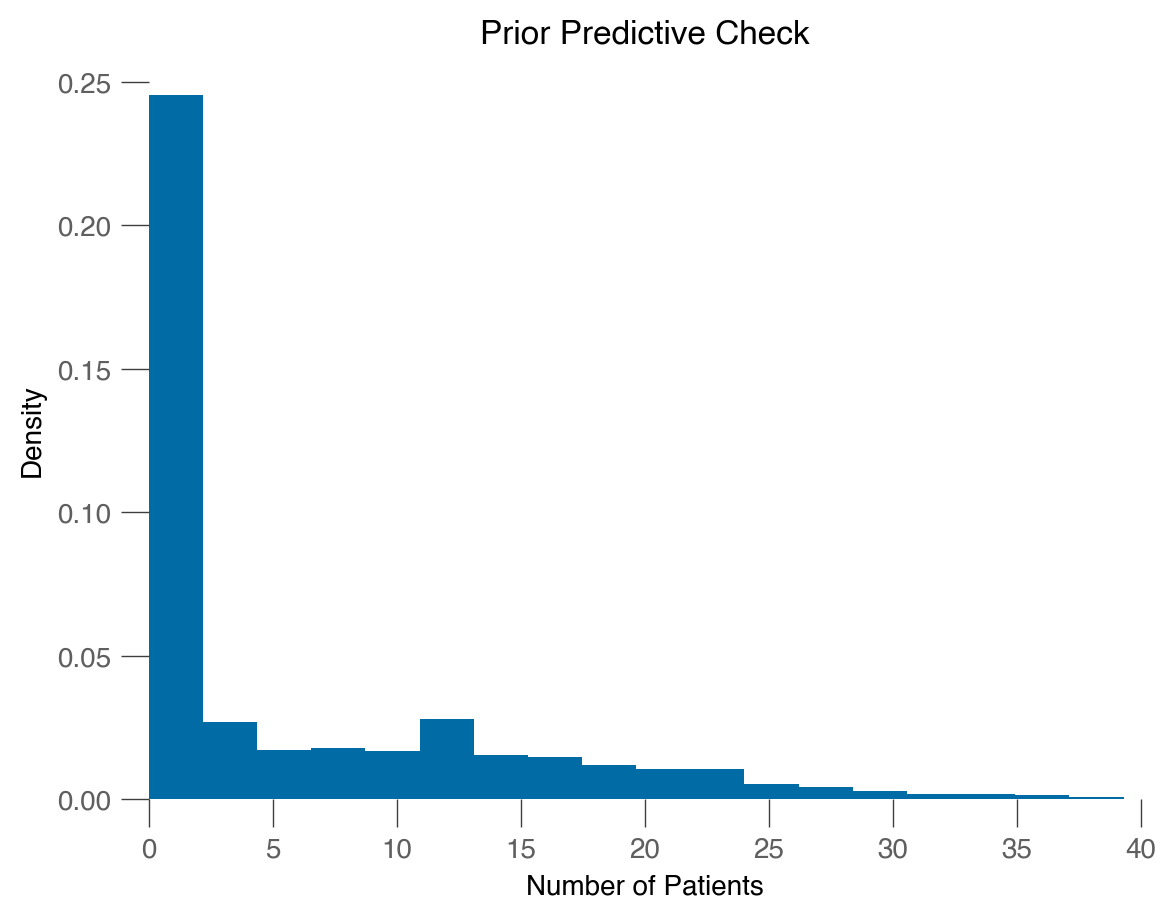

In [59]:
# Plot the prior predictive samples
plt.hist(flattened_array, bins=60, density=True)
plt.xlabel('Number of Patients')
plt.ylabel('Density')
plt.title('Prior Predictive Check')
plt.xlim(0, 40)
plt.show()

Si noti che le distribizioni a priori scelte sono adeguete per rappresentare i dati osservati che corrispondono ad un tasso medio pari a 10.

Eseguiamo ora il campionamento con il modello di pooling completo. Usiamo il sampling JAX per velocizzare il processo.

In [60]:
with model_pooling:
    idata_pooling = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:01.717066
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 539.38it/s]


Sampling time =  0:00:03.924860
Transforming variables...
Transformation time =  0:00:00.009566
Computing Log Likelihood...
Log Likelihood time =  0:00:00.177497


Esaminiamo un sommario delle distribuzioni a posteriori.

In [61]:
az.summary(idata_pooling)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h_mu,10.359,4.529,1.956,18.739,0.112,0.079,1479.0,1037.0,1.0
h_sigma,9.116,8.193,0.199,24.657,0.179,0.126,1241.0,679.0,1.0
rate,9.156,0.246,8.723,9.625,0.006,0.004,1958.0,2004.0,1.0


Questo modello suggerisce che ogni psicologo ha un numero medio di pazienti pari a 10.3 con un intervallo di credibilità al 94% pari a [2.8, 19.2].

## Modello gerarchico

Implementiamo ora un modello gerarchico che tiene in considerazione il ragruppamento dei dati in 5 cluster diversi. Utilizziamo, in questo caso, i dati in formato wide.

Iniziamo a definire delle variabili e coordinate necessarie per specificare la forma delle diverse distribuzioni di densità.

In [91]:
dat_wide.head()

,location_1,location_2,location_3,location_4,location_5
0,12,7,7,8,15
1,12,4,6,9,10
2,6,6,9,7,12
3,13,9,6,14,10
4,12,3,15,6,6


Utilizzando il contenitore `ConstantData`, è possibile assegnare etichette nominate alle dimensioni dei dati. Questo si realizza passando un dizionario di coppie chiave-valore 'dimensione: coordinata' all'argomento `coords` di `pm.Model` durante la creazione del modello. Le coordinate vengono utilizzate per conferire un significato alle dimensioni dei dati e ai parametri nel modello. In questo caso, sono definite due coordinate.

In [96]:
# The data has two dimensions: obs and location
# The "coordinates" are the unique values that these dimensions can take
coords = {"obs": dat_wide.index, "location": dat_wide.columns}
display(coords)

{'obs': RangeIndex(start=0, stop=30, step=1),
 'location': Index(['location_1', 'location_2', 'location_3', 'location_4', 'location_5'], dtype='object')}

Ora definiamo un modello gerarchico che amplia l'approccio precedente includendo le diverse località presenti nei dati. Questo passaggio è cruciale se vogliamo ottenere stime separate dei parametri per ognuna delle cinque località, piuttosto che una stima aggregata. Ecco il codice PyMC che implementa questo modello gerarchico:

In [106]:
with pm.Model(coords=coords) as model_h:
    # Definizione dei dati
    data = pm.ConstantData("observed_score", dat_wide, dims=("obs", "location"))

    # Iperparametri per la distribuzione Gamma
    h_mu = pm.HalfNormal("h_mu", sigma=10)
    h_sigma = pm.HalfNormal("h_sigma", sigma=20)

    # Priori Gamma per ogni località
    lam = pm.Gamma("lam", mu=h_mu, sigma=h_sigma, dims="location")

    # Verosimiglianza Poissoniana per i punteggi
    score = pm.Poisson("score", mu=lam, observed=data, dims=("obs", "location"))

La struttura del modello è la seguente:

1. **Iperparametri**: Innanzitutto, definiamo gli iperparametri `h_mu` e `h_sigma` utilizzando distribuzioni Half-Normal con deviazioni standard di 10 e 20, rispettivamente. Diversamente da una distribuzione normale, la Half-Normal è definita solo per valori positivi.

2. **Distribuzione Gamma per `lam`**: Introduciamo la variabile `lam` con una distribuzione Gamma guidata dagli iperparametri `h_mu` (media) e `h_sigma` (deviazione standard). L'opzione `dims="location"` specifica che `lam` è una variabile multidimensionale, con una dimensione per ogni località. Questo permette di ottenere stime separate per ciascuna delle cinque località.

3. **Verosimiglianza Poissoniana**: L'ultima parte del modello è la funzione di verosimiglianza, modellata attraverso una distribuzione Poisson. Utilizziamo `dims=("obs", "location")` per specificare che per ogni osservazione verrà utilizzato il corrispettivo valore di `lam`, basato sulla località associata all'osservazione.

Questo modello gerarchico è più sofisticato di quello precedente e permette di catturare la struttura regionale nei dati, fornendo stime separate dei parametri per ciascuna delle 5 regioni.

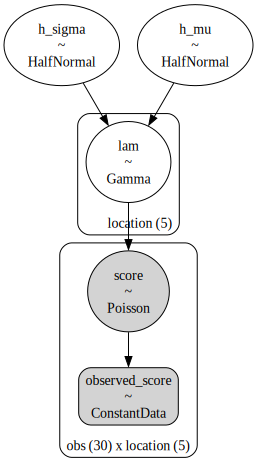

In [107]:
pm.model_to_graphviz(model_h)

Anche in questo caso, iniziamo con il prior predictive check.

In [108]:
with model_h:
    idata_h_prior_pred = pm.sample_prior_predictive()

Sampling: [h_mu, h_sigma, lam, score]


In [109]:
idata_h_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

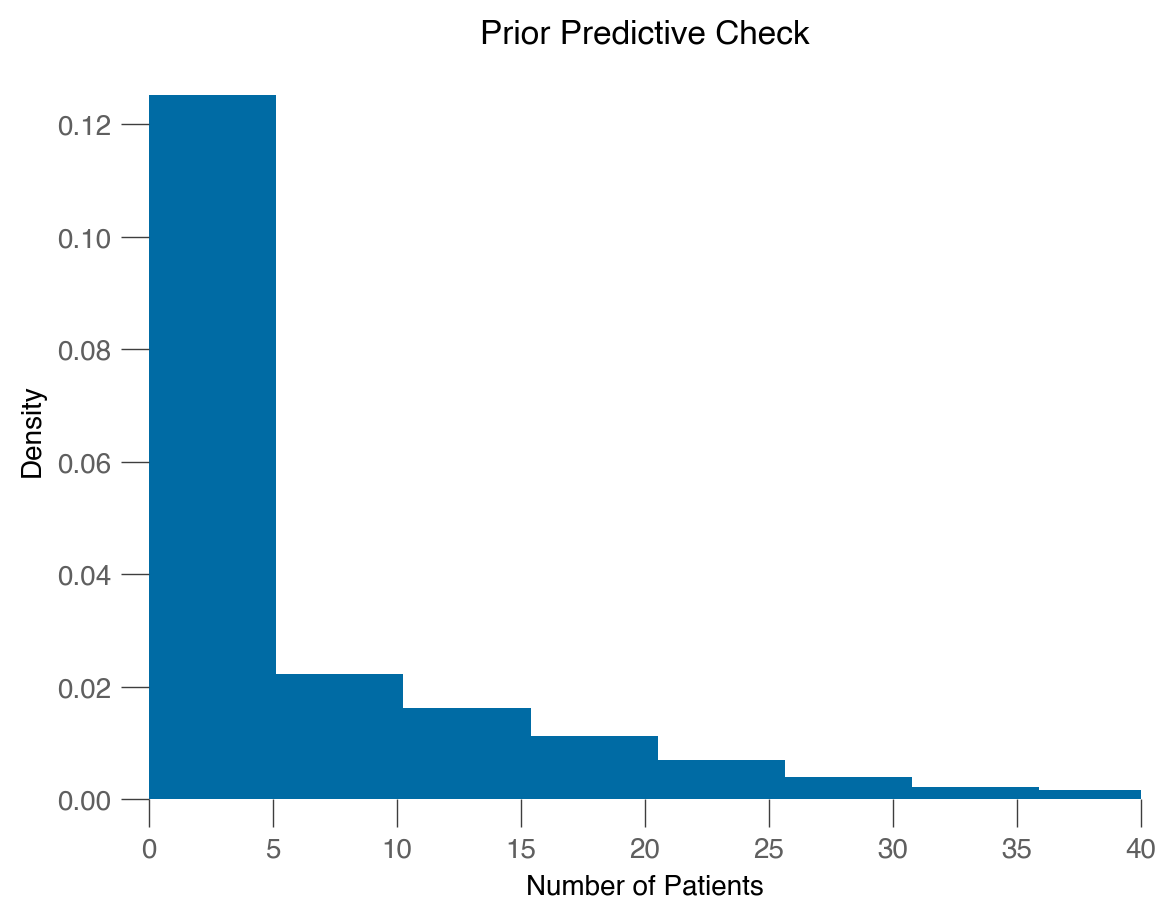

In [110]:
# Extract the likelihood samples
likelihood_samples = idata_h_prior_pred.prior_predictive.score
flattened_array = np.ravel(likelihood_samples.values)

# Plot the prior predictive samples
plt.hist(flattened_array, bins=200, density=True)
plt.xlabel('Number of Patients')
plt.ylabel('Density')
plt.title('Prior Predictive Check')
plt.xlim(0, 40)
plt.show()

Eseguiamo ora il campionamento.

In [111]:
with model_h:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:01.958614
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 507.32it/s]


Sampling time =  0:00:04.194053
Transforming variables...
Transformation time =  0:00:00.012175
Computing Log Likelihood...
Log Likelihood time =  0:00:00.191056


Otteniamo un sommario delle distribuzioni a posteriori. Si noti che otteniamo una distribuzione a posteriori per il tasso di occorrenza nel suo complesso, oltre alla stima del tasso di occorrenza per ciascuna regione.

In [84]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h_mu,9.62,1.70,6.70,12.80,0.05,0.04,1856.64,1161.27,1.0
h_sigma,3.33,2.12,1.02,6.60,0.06,0.04,1905.83,1390.11,1.0
lam[location_1],9.29,0.55,8.29,10.33,0.01,0.01,4591.54,2741.02,1.0
lam[location_2],6.13,0.45,5.26,6.97,0.01,0.00,4146.27,3016.45,1.0
lam[location_3],9.56,0.56,8.48,10.55,0.01,0.01,5050.66,2938.25,1.0
lam[location_4],8.95,0.54,7.96,9.99,0.01,0.01,4504.47,3057.87,1.0
lam[location_5],11.86,0.62,10.71,12.99,0.01,0.01,4464.82,3191.91,1.0


I risultati presentati forniscono un riassunto delle stime a posteriori per i parametri `h_mu`, `h_sigma` e i valori di `lam` per ciascuna delle cinque regioni. Concentrandoci su ESS (Effective Sample Size) e $ r_{\hat{}} $, possiamo fare le seguenti osservazioni:

- **Effective Sample Size (ESS)**:
  - `h_mu` e `h_sigma`: Con valori di ESS bulk rispettivamente di 2271.64 e 1901.29, queste stime indicano che vi è un numero sufficiente di campioni indipendenti per effettuare affermazioni affidabili sui parametri.
  - `lam[1]` a `lam[5]`: I valori ESS per queste stime sono tutti ben al di sopra del migliaio, segnalando una buona efficienza nel campionamento e una convergenza affidabile.

- **$ r_{\hat{}} $**:
  - Per tutti i parametri, il valore di $ r_{\hat{}} $ è 1.0, il che è un segnale positivo. Un valore di $ r_{\hat{}} $ così vicino a 1 indica che le catene di Markov hanno realizzato la convergenza in modo appropriato e che non c'è evidenza di non convergenza. Questo implica che i risultati sono affidabili e che le inferenze possono essere fatte con confidenza.

In sintesi, sia l'ESS che i valori di $ r_{\hat{}} $ per questi parametri suggeriscono che il modello ha campionato efficacemente lo spazio dei parametri, e che le stime a posteriori sono attendibili. Le stime di `h_mu` e `h_sigma` ci forniscono un'indicazione chiara dell'incertezza a priori sulla media e sulla deviazione standard della distribuzione gamma del tasso di occorrenza, mentre i valori per `lam` ci offrono le stime a posteriori del tasso di occorrenza nelle diverse regioni.

È importante notare che, sebbene la stima del tasso di occorrenza possa apparire simile a quella ottenuta con il modello non gerarchico, il modello gerarchico fornisce un intervallo di credibilità decisamente più stretto per la stima di questo parametro rispetto al modello non gerarchico. Questo aspetto rivela che, utilizzando il modello non gerarchico e trascurando quindi la struttura raggruppata dei dati, si finisce per sovrastimare l'incertezza della nostra stima del parametro di interesse. In altre parole, il modello gerarchico tiene conto delle correlazioni tra i gruppi, offrendo una rappresentazione più realistica dell'incertezza nella stima del tasso di occorrenza.

Inoltre, abbiamo ottenuto una stima del tasso di occorrenza separatamente per ciascuna regione. Si noti che ci sono grandi variazioni tra le regioni. Nella regione 5, il numero medio di pazienti per psicologo è quasi 12, mentre nella regione 2 questo valore si riduce alla metà.

Nella figura seguente, i medesimi dati sono rappresentati mediante un "forest plot" del parametro `rate`, che rappresenta il numero di pazienti per ciascuno psicoloog, insieme all'intervallo di credibilità Highest Density Interval (HDI) al 94%. 

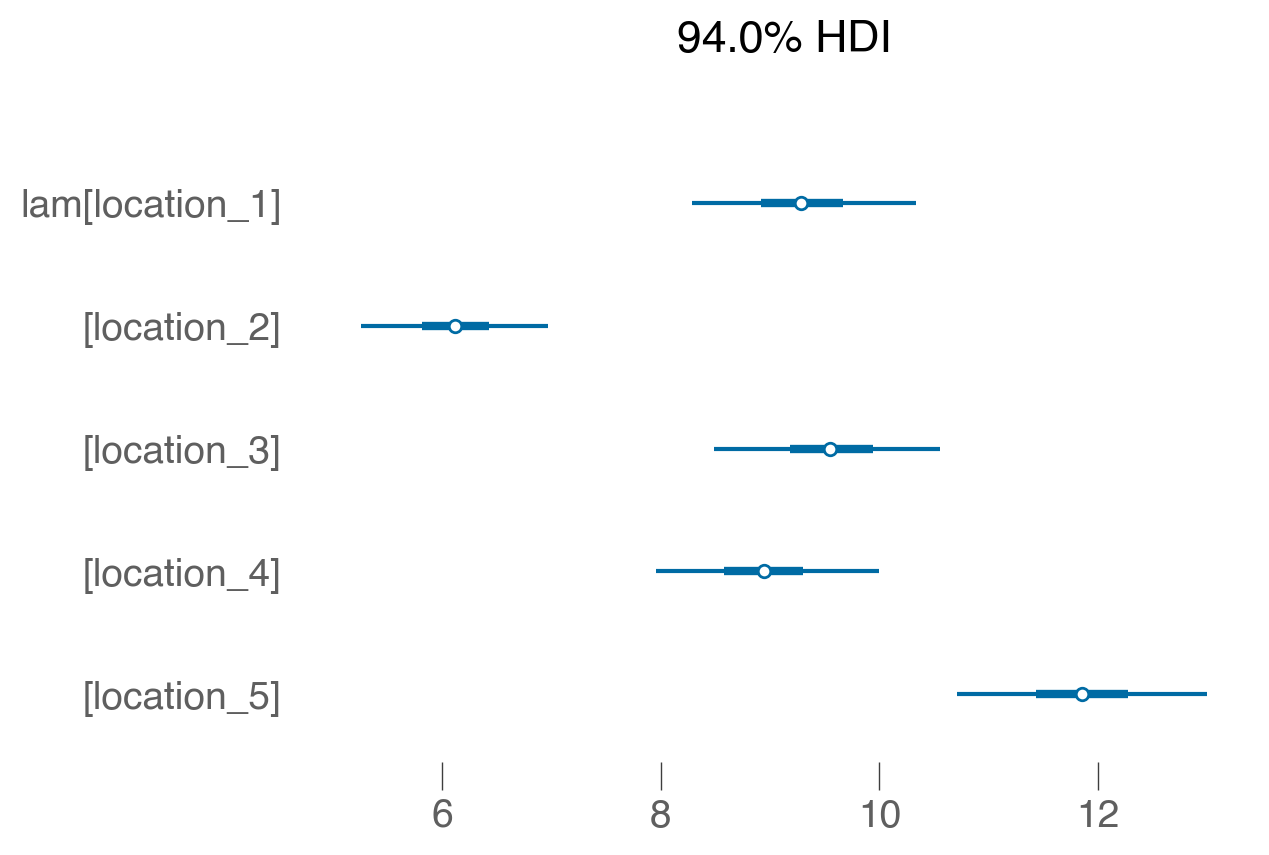

In [85]:
samples_lam = idata.posterior["lam"]
az.plot_forest(samples_lam, combined=True, hdi_prob=0.94)
plt.show()

Esaminiamo ora una rappresentazione grafica della distribuzione a posteriori dei parametri `h_mu` e `h_sigma`, che rappresentano l'incertezza sulla media e sulla deviazione standard della distribuzione gamma del parametro "tasso di occorrenza". Nel contesto del nostro modello gerarchico:

- **`h_mu`** è l'iper-parametro che rappresenta la media a priori della distribuzione gamma del tasso di occorrenza.
- **`h_sigma`** è l'iper-parametro che rappresenta la deviazione standard a priori della distribuzione gamma del tasso di occorrenza.

La visualizzazione delle distribuzioni a posteriori e delle tracce si può ottenere con il seguente comando.

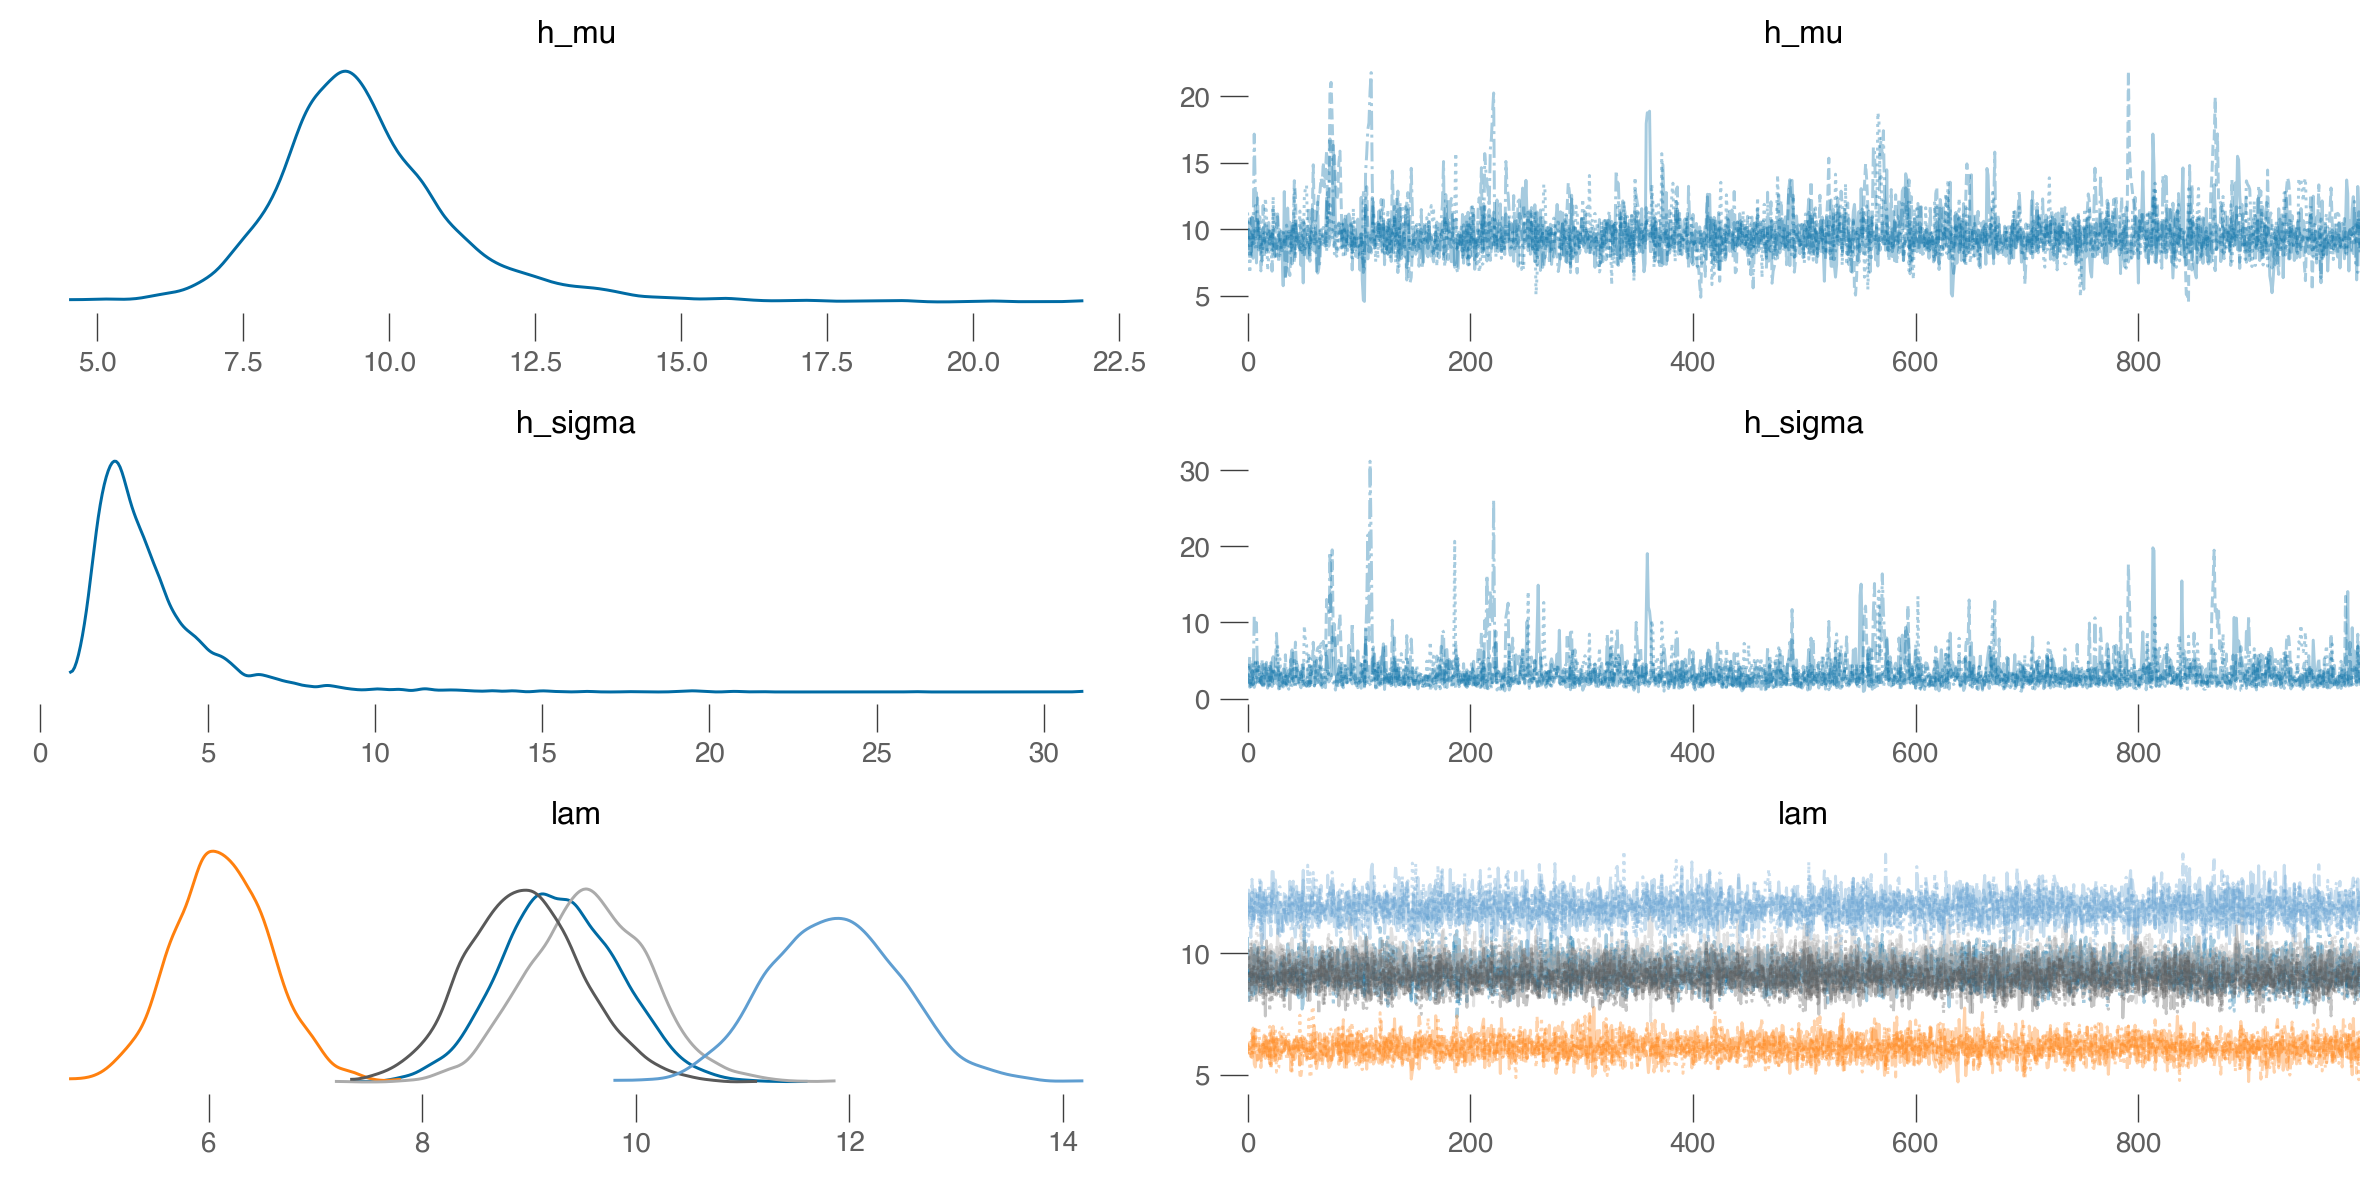

In [86]:
az.plot_trace(idata, combined=True)
plt.tight_layout()
plt.show()

Concludiamo, infine, con il posterior predictive check.

In [87]:
with model_h:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [score]


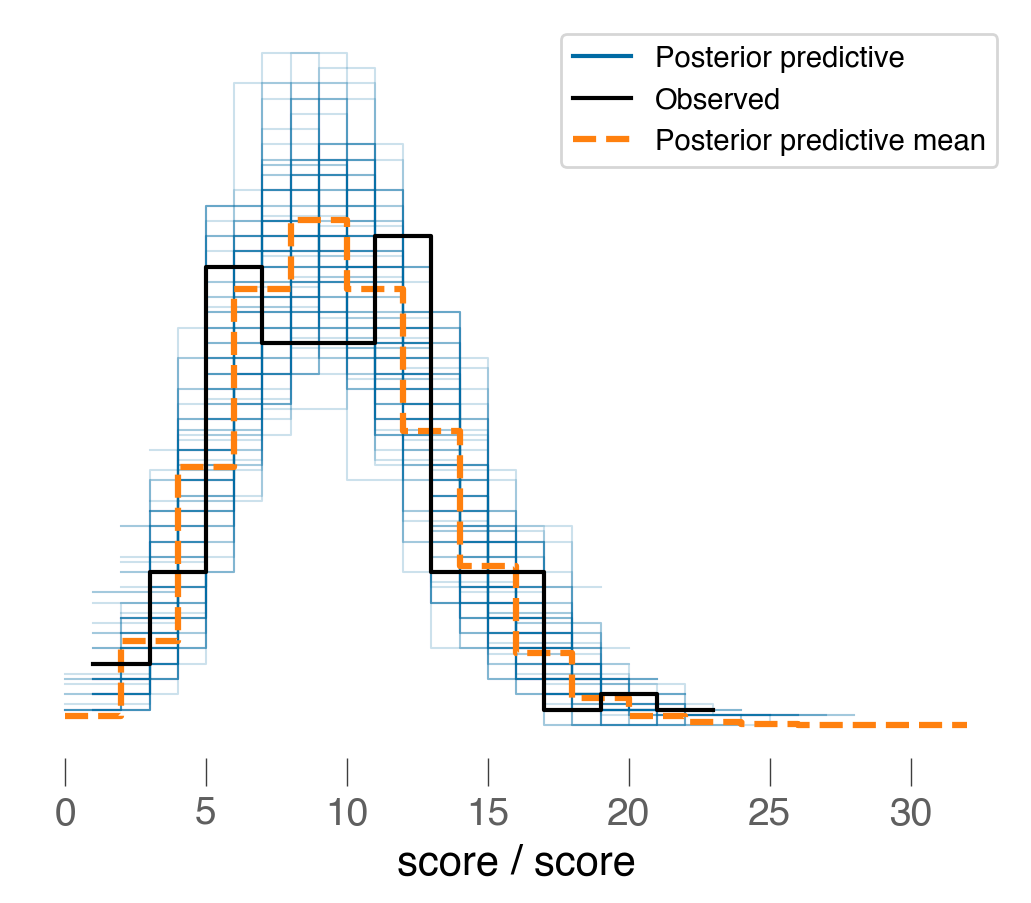

In [88]:
az.plot_ppc(post_pred, num_pp_samples=100)
plt.show()

Il controllo predittivo a posteriori mostra che il modello è stato in grado di rappresentare adeguatamente i dati osservati. Questo indica una buona adattabilità del modello, confermando che le supposizioni fatte e la struttura del modello sono coerenti con le informazioni ricavate dai dati.

## Confronto tra modelli

Ora vogliamo esaminare se esistono vantaggi nell'utilizzare un modello gerarchico rispetto a un modello di pooling completo. Per questo confronto, utilizzeremo la metrica dell'*Expected Log Predictive Density* (ELPD).

È importante notare che non è possibile confrontare direttamente gli ELPD dei due modelli PyMC precedentemente descritti, in quanto sono stati addestrati su formati di dati diversi: il modello gerarchico su dati in formato wide e il modello di pooling completo su dati in formato long. Per un confronto valido dell'ELPD, è necessario adattare entrambi i modelli ai dati presentati nello stesso formato.

Per affrontare questo problema, ricorreremo a `bambi`, che è un wrapper di alto livello per PyMC. Sebbene `bambi` sfrutti PyMC per il campionamento, permette di definire il modello con una sintassi molto più semplice. Inoltre, offre priori "intelligenti" predefiniti, eliminando quindi la necessità di specificare manualmente le distribuzioni a priori.

Nel nostro caso, adatteremo entrambi i modelli ai dati presentati in formato long.

In [30]:
dat_long.head()

NameError: name 'dat_long' is not defined

Definiamo il modello gerarchico nella sintassi richiesta da `bambi`:

In [ ]:
model_hierarchical = bmb.Model(
    "patients ~ 1 + (1 | location)", dat_long, family="poisson"
)

La formula `"patients ~ 1 + (1 | location)"` è un'espressione concisa per definire un modello lineare generalizzato misto (GLMM). Vediamo in dettaglio cosa significa ciascun pezzo della formula:

- `patients`: è la variabile dipendente (o variabile target) che stiamo cercando di modellare. In questo caso, rappresenta il numero di pazienti.
  
- `~`: separa la variabile dipendente dalla parte del modello che descrive i predittori.
  
- `1`: indica un termine d'intercetta nel modello. In pratica, aggiunge una costante a tutti i livelli del modello.
  
- `+`: è un operatore che aggiunge ulteriori termini al modello. In questo caso specifico, stiamo aggiungendo un effetto casuale.
  
- `(1 | location)`: è un termine che indica un effetto casuale. L'effetto casuale è specificato per la variabile `location`. Il modello prevede che ci siano diversi livelli di `location` e che ciascuno di essi abbia una propria intercetta casuale. L'uso di `(1 | location)` indica che stiamo modellando un effetto casuale di intercetta per ogni `location` ma non stiamo considerando effetti casuali di pendenza.

In termini più tecnici, il modello può essere descritto dalle seguenti equazioni:


$$
\begin{align}
\text{patients}_{i} &\sim \text{Poisson}(\lambda_{i})\notag\\
\log(\lambda_{i}) &= \alpha + \alpha_{\text{location}[i]}\notag\\
\alpha &\sim \text{Normale}(0, \sigma_{\alpha})\notag\\
\alpha_{\text{location}} &\sim \text{Normale}(0, \sigma_{\text{location}})\notag
\end{align}
$$

- $\text{patients}_{i}$ è il numero di pazienti nell'osservazione $i$.
- $\lambda_{i}$ è il tasso per l'osservazione $i$.
- $\alpha$ è l'intercetta globale del modello.
- $\alpha_{\text{location}[i]}$ è l'effetto casuale dell'intercetta per la località della $i$-esima osservazione.
- $\sigma_{\alpha}$ e $\sigma_{\text{location}}$ sono le deviazioni standard delle distribuzioni normali da cui sono estratti $\alpha$ e $\alpha_{\text{location}}$, rispettivamente.

Eseguiamo ora il campionamento. L'argomento `idata_kwargs={"log_likelihood": True}` specifica che richiediamo la log-verosimiglianza necessaria per stimare ELPD.

In [150]:

model_hierarchical_fitted = model_hierarchical.fit(
    draws=2000,
    target_accept=0.85,
    random_seed=RANDOM_SEED,
    method="nuts_numpyro", 
    idata_kwargs={"log_likelihood": True},
)

Compiling...
Compilation time =  0:00:01.307384
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]








Running chain 0:  45%|████▌     | 1350/3000 [00:03<00:00, 13056.58it/s]

Running chain 0:  95%|█████████▌| 2850/3000 [00:03<00:00, 13653.18it/s]

Running chain 3: 100%|██████████| 3000/3000 [00:03<00:00, 849.52it/s]  


Sampling time =  0:00:03.737313
Transforming variables...
Transformation time =  0:00:00.034696
Computing Log Likelihood...
Log Likelihood time =  0:00:00.425693


Esaminiamo le distribuzioni a posteriori dei parametri. Si noti che Bambi ha trasformato internamente i dati per garantire stabilità numerica ed efficienza computazionale, utilizzando una scala logaritmica.

In [155]:
summary = az.summary(model_hierarchical_fitted)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.187,0.178,1.863,2.582,0.006,0.004,1036.0,1219.0,1.01
1|location_sigma,0.364,0.198,0.116,0.734,0.006,0.005,1184.0,1471.0,1.00
1|location[location_1],0.039,0.185,-0.319,0.410,0.006,0.004,1112.0,1258.0,1.00
1|location[location_2],-0.377,0.187,-0.757,-0.019,0.006,0.004,1154.0,1336.0,1.00
1|location[location_3],0.066,0.184,-0.279,0.440,0.006,0.004,1067.0,1319.0,1.00
1|location[location_4],0.002,0.184,-0.388,0.343,0.006,0.004,1103.0,1351.0,1.00
1|location[location_5],0.288,0.183,-0.057,0.662,0.006,0.004,1086.0,1274.0,1.00


Per convertire queste stime alla scala naturale, è possibile applicare l'inverso della trasformazione alle statistiche riassuntive.

In [160]:
(
    np.exp(summary["mean"][0] + summary["mean"][2]),
    np.exp(summary["mean"][0] + summary["mean"][3]),
    np.exp(summary["mean"][0] + summary["mean"][4]),
    np.exp(summary["mean"][0] + summary["mean"][5]),
    np.exp(summary["mean"][0] + summary["mean"][6]),
)

(9.262740914994835,
 6.110447432230608,
 9.516241781405713,
 8.926282367701774,
 11.881707113099395)

Adattiamo ora ai dati il modello di pooling completo. Questo produrrà un'unica stima del parametro *rate*.

In [161]:
model_pooling = bmb.Model("patients ~ 1", dat_long, family="poisson")
model_pooling_fitted = model_pooling.fit(
    draws=2000,
    target_accept=0.85,
    random_seed=RANDOM_SEED,
    method="nuts_numpyro", 
    idata_kwargs={"log_likelihood": True},
)

Compiling...
Compilation time =  0:00:01.239733
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 3000/3000 [00:02<00:00, 1045.88it/s]


Sampling time =  0:00:03.059731
Transforming variables...
Transformation time =  0:00:00.007038
Computing Log Likelihood...
Log Likelihood time =  0:00:00.191062


In [162]:
summary2 = az.summary(model_pooling_fitted)
summary2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.214,0.027,2.166,2.264,0.0,0.0,2946.0,3005.0,1.0


In [163]:
np.exp(summary2["mean"][0])

9.152252281675231

Ora possiamo procedere al confronto tra il modello gerarchico e il modello di pooling completo, utilizzando la differenza dei loro valori ELPD come criterio. Eseguire un confronto tra modelli bayesiani è molto semplice con `az.compare()`. In questo specifico caso, forniamo un dizionario che contiene gli oggetti InferenceData generati da `Model.fit()`. In risposta, `az.compare()` restituisce un dataframe ordinato dal modello migliore al modello peggiore, in base al criterio ELPD.

In [153]:
models = {"hierarchical": model_hierarchical_fitted, "pooling": model_pooling_fitted}
df_compare = az.compare(models)
df_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-394.643656,5.745384,0.000000,0.980909,10.656570,0.000000,False,log
pooling,1,-421.941401,1.548813,27.297745,0.019091,13.361812,8.336277,False,log


La differenza nei valori di ELPD è di 27.3, con un errore standard associato alla differenza di 8.34. Il rapporto tra la differenza ELPD e il suo errore standard è superiore a 3, indicando una credibile differenza tra i due modelli. Sulla base di questi risultati statistici, possiamo concludere che il modello gerarchico offre una migliore aderenza ai dati rispetto al modello non gerarchico.

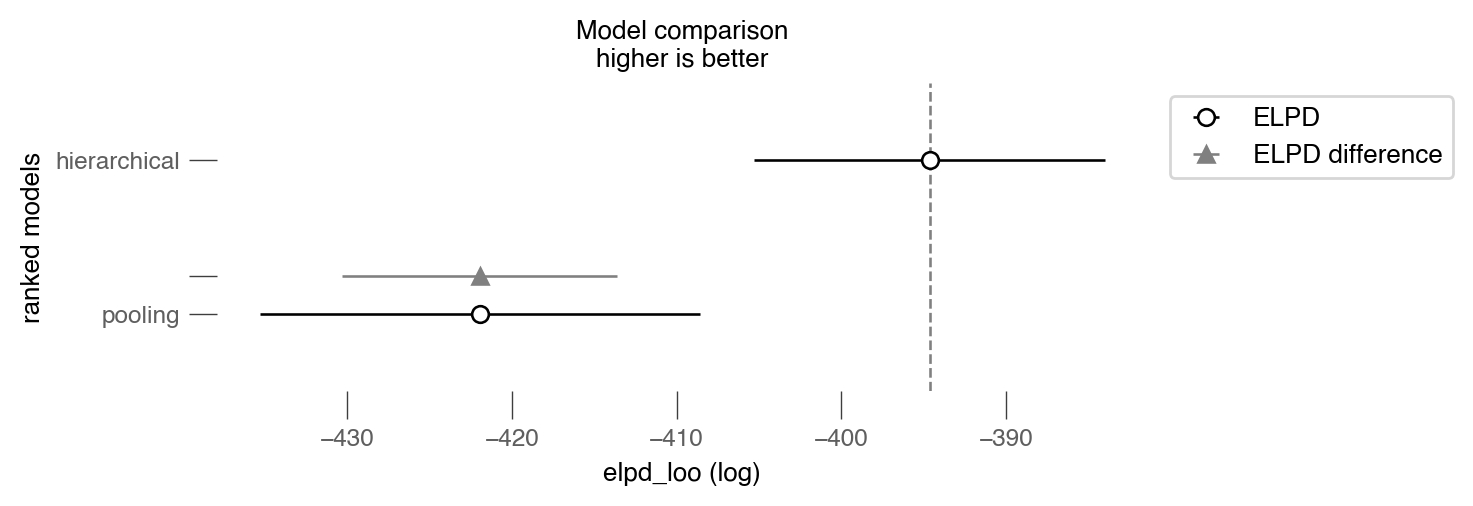

In [154]:
az.plot_compare(df_compare, insample_dev=False)
plt.show()

## Watermark

In [166]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Aug 30 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.14.0

scipy     : 1.11.2
pymc      : 5.7.2
pandas    : 2.0.3
arviz     : 0.16.1
seaborn   : 0.12.2
numpy     : 1.25.2
bambi     : 0.12.0
matplotlib: 3.7.2

Watermark: 2.4.3

